# The *QuantNbody* package:
## Exact diagonalization for many-body Hamiltonians

**Saad Yalouz**

**GOALS :** 

- **1st Part :** Illustrating how we can use the **QuantNbody** package to build many-electron Hamiltonians $\hat{H}$  (e.g. Hubbard molecule model and electronic structure), and any other important operator.

- **2nd Part :** Providing some details about how it is made inside the code **(NO BLACK BOX !)**.

## Let's start with a quick demo 

In the local site basis, the model Hamiltonian is usually expressed such that:

$$ 
\hat{H} = \color{blue}{\sum_{\langle i,j \rangle}^{N_{MO}} -t_{ij} \sum_{\sigma=\uparrow,\downarrow} (\hat{a}^\dagger_{j,\sigma}\hat{a}_{i,\sigma}+\hat{a}^\dagger_{i,\sigma}\hat{a}_{j,\sigma})} 
+ \color{red}{\sum_i^{N_{MO}} \mu_{ii} \sum_{\sigma=\uparrow,\downarrow} \hat{a}^\dagger_{i,\sigma}\hat{a}_{i,\sigma} }
+ \color{black}{
\sum_i^{N_{MO}} U_{iiii} \hat{a}^\dagger_{i,\uparrow}\hat{a}_{i,\uparrow} \hat{a}^\dagger_{i,\downarrow}\hat{a}_{i,\downarrow} 
}
$$

with :
- <font color='blue'> $t_{ij}$ the hopping terms between the pair of connected sites $\langle i, j \rangle$.  
- <font color='red'> $\mu_{ii}$ the local chemical potential on site "$i$".
- <font color='black'> $U_{iiii}$ the local coulombic repulsion on site "$i$".
    

<img src="graph.png" width="400"  style="margin:auto"/>

In a more general basis (not necessarily local) we have
$$   
\hat{H} =\sum_{\langle p,q \rangle}^{N_{MO}} -h_{pq} \sum_{\sigma=\uparrow,\downarrow} (\hat{a}^\dagger_{p,\sigma}\hat{a}_{q,\sigma}+\hat{a}^\dagger_{q,\sigma}\hat{a}_{p,\sigma}) + \sum_i^{N_{MO}} U_{p,q,r,s} \hat{a}^\dagger_{p,\uparrow}\hat{a}_{q,\uparrow} \hat{a}^\dagger_{r,\downarrow}\hat{a}_{s,\downarrow} 
 $$
where for commodity we have introduced the one-body integral term $h_{pq}$ which embed the hopping terms and the chemical potentials such as
$$
h_{pq} = \sum_{i,j}^{N_{MO}} (-t_{ij} + \delta_{ij}\mu_{ii}) C_{i,p} C_{j,q} 
$$
and the "delocalized version" of the coulombic repulsion term
$$
U_{pqrs} = \sum_{i}^{N_{MO}}  U_{i,i,i,i} C_{i,p} C_{i,q} C_{i,r} C_{i,s}
$$
where the matrix ${\bf C}$ encodes the Molecular Orbital coefficient if we want for example to express the Hamiltonian in a delocalized basis.

In [1]:
import quantnbody as qnb # <=== OUR PACKAGE !!!!

import numpy as np  
import scipy
from itertools import combinations_with_replacement, product, combinations
import math    
from openfermion.ops import FermionOperator
from openfermion import transforms
import openfermion 
np.set_printoptions(precision=3) # For nice numpy matrix printing

### Model parameters

We first define the hopping between the sites $t$, the chemical potentials $\mu$ and the electronic repulsion $U$.

In [2]:
# Setup for the simulation ========
N_MO   = N_elec = 2 
dim_H = math.comb( 2*N_MO, N_elec ) # Dimension of the many-body space

t_  = np.zeros((N_MO,N_MO))
U_  = np.zeros((N_MO,N_MO,N_MO,N_MO))
Mu_ = np.zeros((N_MO,N_MO)) 
for i in range(N_MO): 
    U_[i,i,i,i]  =  1 * (1+i)  # Local coulombic repulsion 
    Mu_[i,i]     = -1 * (1+i)  # Local chemical potential
    
    for j in range(i+1,N_MO): 
        t_[i,j] = t_[j,i] = - 1  # hopping

h_ = t_  + np.diag( np.diag(Mu_) ) # Global one-body matrix = hoppings + chemical potentials

print( 't_=\n',t_ ,'\n')

print( 'Mu_=\n',Mu_ ,'\n')

print( 'h_=\n',h_ ,'\n')

t_=
 [[ 0. -1.]
 [-1.  0.]] 

Mu_=
 [[-1.  0.]
 [ 0. -2.]] 

h_=
 [[-1. -1.]
 [-1. -2.]] 



### Building the basis of N-body states

We create a list (a basis) of many-body state which describe the repartition of $N_{elec}$ electrons in $2N_{MO}$ spin-orbitals  

$$
\Big\lbrace |\kappa \rangle \Big\rbrace_{\textstyle \kappa=1}^{\textstyle \dim_H}
$$ 

which is indexed by the label "$\kappa$"

The dimension $\dim_H$ of the many-body basis depends on $N_{elec}$ and $N_{MO}$ via a binomial law such that

$$\dim_H = \binom{2N_{MO}}{N_{elec}}$$

**A little example with $N_{MO}=N_{elec}=2$ :** In this case, we have 6 many-body states.

In [3]:
obj = qnb.Hamiltonian(N_MO, N_elec) 
# when we call constructor of the class we also generate nbody_basis (that will be saved in the obj.nbody_basis)


print( '| kappa ⟩', '= many-body state',  )
kappa = 0
for state in obj.nbody_basis:
    print( '| {} ⟩'.format(kappa), '    =', state )
    kappa += 1

| kappa ⟩ = many-body state
| 0 ⟩     = [1 1 0 0]
| 1 ⟩     = [1 0 1 0]
| 2 ⟩     = [1 0 0 1]
| 3 ⟩     = [0 1 1 0]
| 4 ⟩     = [0 1 0 1]
| 5 ⟩     = [0 0 1 1]


**Nota Bene :** on the meaning of the many-body states :

- Couple of terms refer to a same spatial orbital
-  Even indices refer to $\alpha$-spinorbital  
-  Odd indices refer to $\beta$-spinorbital  
    
$$| \kappa  = 0\rangle = | \underbrace{   \overbrace{1}^{ \textstyle  {\alpha}}, \; \; \;\overbrace{1}^{ \textstyle  {\beta}},}_{\textstyle 1st \ MO}\; \; \underbrace{\overbrace{0}^{ \textstyle  {\alpha}}, \; \; \; \overbrace{0}^{ \textstyle  {\beta}}}_{\textstyle 2nd \ MO} \rangle$$

### Building the operators $a^\dagger_{p,\sigma} a_{q,\sigma}$

A key element to build almost everyting we need (Hamiltonian, RDMs ...) is the matrix representation of the operators $a^\dagger_{p,\sigma} a_{q,\sigma}$ in the many-body basis.  


<!-- 
**But we will see how to do that in practice later on !!!!**  -->

<!-- For the moment, let's call the function which builds these operators !! -->

In [4]:
obj.build_operator_a_dagger_a(silent=True)  # in this case a_dagger_a is saved in obj.a_dagger_a
print(obj.a_dagger_a.shape)

(4, 4)


### Building the Hamiltonian

We pass three ingredients to the function:
- Parameters of the model
- The Many-body basis
- The $a^\dagger a $ operators

In [5]:
obj.build_hamiltonian_fermi_hubbard(h_, U_)

print('H (SPARSE) =' )
print(obj.H)

H (SPARSE) =
  (0, 0)	-1.0
  (0, 2)	-1.0
  (0, 3)	1.0
  (1, 1)	-3.0
  (2, 0)	-1.0
  (2, 2)	-3.0
  (2, 5)	-1.0
  (3, 0)	1.0
  (3, 3)	-3.0
  (3, 5)	1.0
  (4, 4)	-3.0
  (5, 2)	-1.0
  (5, 3)	1.0
  (5, 5)	-2.0


In [6]:
print('H (DENSE) =' )
print(obj.H.A)

H (DENSE) =
[[-1.  0. -1.  1.  0.  0.]
 [ 0. -3.  0.  0.  0.  0.]
 [-1.  0. -3.  0.  0. -1.]
 [ 1.  0.  0. -3.  0.  1.]
 [ 0.  0.  0.  0. -3.  0.]
 [ 0.  0. -1.  1.  0. -2.]]


We diagonalize the resulting matrix and we visualize the ground state

In [7]:
obj.diagonalize_hamiltonian(full=True)
obj.eig_values # <-- eigenvalues
obj.eig_vectors # <-- eigenvalues

print('Energies =', obj.eig_values[0:4] )

WFT = obj.eig_vectors[:,0]

# Visualizing the groundstate in the many-body basis
qnb.tools.visualize_wft(WFT, obj.nbody_basis, cutoff=0.00) # <=== FCT IN THE PACKAGE
print()

Energies = [-4.414 -3.    -3.    -3.   ]

	-----------
	 Coeff.      N-body state
	-------     -------------
	-0.57454	|0110⟩
	+0.57454	|1001⟩
	+0.47596	|0011⟩
	+0.33656	|1100⟩




### Alternative way of building Hamiltionian
Instead of using class `Hamiltonian` we can also use tools functions:

In [8]:
nbody_basis = qnb.tools.build_nbody_basis( N_MO, N_elec ) # <=== FCT IN THE PACKAGE
a_dagger_a = qnb.tools.build_operator_a_dagger_a(nbody_basis)
H = qnb.tools.build_hamiltonian_fermi_hubbard( h_, U_,  nbody_basis, a_dagger_a ) # <=== FCT IN THE PACKAGE
eig_energies, eig_vectors =  scipy.linalg.eigh(H.A)

### Building different types of RDM from the groundstate

In [9]:
# Building the 1-RDM of the groundstate in the original many-body basis
one_rdm_alpha = qnb.tools.build_1rdm_alpha(WFT, obj.a_dagger_a)     # <=== FCT IN THE PACKAGE
one_rdm_beta  = qnb.tools.build_1rdm_beta(WFT, obj.a_dagger_a)      # <=== FCT IN THE PACKAGE
one_rdm       = qnb.tools.build_1rdm_spin_free(WFT, obj.a_dagger_a) # <=== FCT IN THE PACKAGE

two_rdm       = qnb.tools.build_2rdm_fh_on_site_repulsion(WFT, obj.a_dagger_a) # <=== FCT IN THE PACKAGE

In [10]:
def E_( P, Q ):
    """
    >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    Function to create one fermionic singlet
    excitation operator : E_PQ (element of the  MO 1-electron RDM)
    >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    """
    return (  FermionOperator('{}^ {}'.format( 2*P, 2*Q ))
            + FermionOperator('{}^ {}'.format( 2*P+1, 2*Q+1 )) )  


H_FH = FermionOperator.zero()
for p in range(N_MO):
    n_up   = FermionOperator('{}^ {}'.format( 2*p, 2*p ) )
    n_down = FermionOperator('{}^ {}'.format( 2*p+1, 2*p+1 ))
    H_FH +=  U_[p,p,p,p] *  n_up * n_down + Mu_[p,p] * ( n_up + n_down )
    for q in range(N_MO):
        H_FH +=  E_( p, q) * t_[p,q]
        
H_FH_JW = transforms.jordan_wigner( H_FH )
H_FH_sparse = openfermion.get_sparse_operator( H_FH_JW, n_qubits=2*N_MO )

number_operator = FermionOperator('0^ 0')
for i in range(1,2*N_MO):
    number_operator += FermionOperator( '{0}^ {0}'.format(i) )
        
# We build the projector onto the subspace spanning the 4 electrons fock states 
number_operator_jw = transforms.jordan_wigner(number_operator)
number_operator_sparse = openfermion.get_sparse_operator(number_operator_jw,n_qubits=2*N_MO) 
number_operator_eig = scipy.linalg.eigh(number_operator_sparse.A)
n_projector_basis   = number_operator_eig[1][ :,   np.round(number_operator_eig[0]) == N_elec   ] 
n_projector = np.einsum('ji, ki', n_projector_basis, n_projector_basis.conjugate(), optimize=True)  
 
H_FH_  = n_projector @ H_FH_sparse.A @  n_projector

OF_eig_energies, OF_eig_vectors = scipy.linalg.eigh( H_FH_ ) #scipy.sparse.linalg.eigsh(H, k=4) 

### Comparison of the energies from Openfermion and from our package

In [11]:
print( ' Our Quant_Nbody package ', *obj.eig_values[0:4] )
print( ' Openfermion package     ', *OF_eig_energies[0:4] )

print( np.allclose(obj.eig_values[0:4], OF_eig_energies[0:4]) ) 

 Our Quant_Nbody package  -4.414213562373096 -3.0 -3.0 -3.0
 Openfermion package      -4.414213562373091 -3.0000000000000018 -3.0 -2.999999999999999
True


## Electronic structure Hamiltonian (SEE NOTEBOOK !)

In [12]:
import numpy as np
from tqdm import tqdm
import quantnbody as qnb
import math
import pyscf 
import sys
from pyscf import gto, scf, ao2mo, mcscf, fci 
 
list_theta = np.linspace(num = 30, start=20. * np.pi/180., stop=160. * np.pi/180., endpoint=True) 
E_HF  = []
E_FCI = []
E_FCI_me = []

N_elec = N_MO = 4
dim_H  = math.comb(2*N_MO, N_elec)

mol_qnb = qnb.Hamiltonian(N_MO, N_elec)
  
MAX_ROOT = 15

dim_parameter = len(list_theta)
Energies_FCI    = np.zeros((dim_parameter,MAX_ROOT))
Energies_FCI_me = np.zeros((dim_parameter,dim_H)) 


mol_qnb.build_operator_a_dagger_a()
S_2, S_plus, S_z =  qnb.tools.build_s2_sz_splus_operator(mol_qnb.a_dagger_a)
# for r in tqdm(list_r):
elem = 0
for theta in tqdm(list_theta, file=sys.stdout): 
    r = 1.
     
    XYZ_geometry = """ H   {0}   {1}  0.
                       H   {0}  -{1}  0. 
                       H  -{0}   {1}  0.
                       H  -{0}  -{1}  0.  """.format( r*np.cos(theta/2.), r*np.sin(theta/2.) ) 
     
    mol = gto.Mole()
    mol.build( atom     = XYZ_geometry,  # in Angstrom
               basis    = 'STO-3G',
               symmetry = False,
               spin     = 0 )

    mf = scf.RHF(mol)
    print('      ', end='')
    mf.kernel() 
    FCI_solver = pyscf.fci.FCI( mf, mf.mo_coeff  )  
    FCI_solver = fci.addons.fix_spin_(FCI_solver, ss=0, shift=10 ) 
    
    FCI_solver.nroots = MAX_ROOT
    E_FCI_pyscf, Wfn_FCI = FCI_solver.kernel()           
    h_MO = np.einsum('pi,pq,qj->ij', mf.mo_coeff,
                           mol.intor_symmetric('int1e_kin') + mol.intor_symmetric('int1e_nuc'),
                           mf.mo_coeff) 
    g_MO  = ao2mo.kernel( mol, mf.mo_coeff )
    g_MO  = ao2mo.restore('s1', g_MO, N_MO)
 

    E_rep_nuc = mol.energy_nuc()                  # Nuclei repuslion energy
 
    mol_qnb.build_hamiltonian_quantum_chemistry(h_MO, g_MO)  
    eig_energies, eig_vectors =  np.linalg.eigh(mol_qnb.H.A) 
    E_FCI_me += [ E_rep_nuc + eig_energies[0] ]
    
    Energies_FCI_me[elem,:] = [ E_rep_nuc + eig_energies[p]  for p in range(dim_H) ] 
    
    Energies_FCI[elem,:] = E_FCI_pyscf
    
    elem += 1 


	 ====  The matrix form of a^a is built  ====
  0%|          | 0/30 [00:00<?, ?it/s]      converged SCF energy = -1.53885163577021


Overwritten attributes  contract_2e  of <class 'pyscf.fci.FCI.<locals>.CISolver'>


100%|██████████| 30/30 [01:21<00:00,  2.71s/it]


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


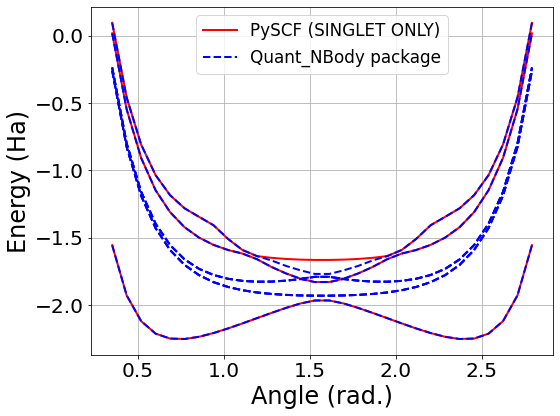

In [13]:
import matplotlib.pyplot as plt

plt.rc('font',  family='serif')
plt.rc('font',  serif='Times New Roman')
plt.rc('font',  size='14') 
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large') 
plt.rc('lines', linewidth='2') 

# Plotting the resulting energies
fig, ( ax1 ) = plt.subplots( nrows=1, ncols=1, figsize=(8, 6)  ) 
for i in range(3):
    if i ==0:
        ax1.plot( list_theta, Energies_FCI[:,i], color='red' , label='PySCF (SINGLET ONLY)' ) 
    else:
        ax1.plot( list_theta, Energies_FCI[:,i], color='red'   ) 
for i in range(9):
    if i ==0: 
        ax1.plot( list_theta, Energies_FCI_me[:,i], color='blue', ls='--' , label='Quant_NBody package'    )  
    else:
        ax1.plot( list_theta, Energies_FCI_me[:,i], color='blue', ls='--'   ) 
ax1.grid()


ax1.set_ylabel('Energy (Ha)', size=24)
ax1.set_xlabel('Angle (rad.)', size=24)
ax1.legend(fontsize='large', ncol=1)

plt.tight_layout()

plt.savefig('PES_H4_ring.pdf')
  
plt.show()
 
 

**Let us check the spin of the low lying states**

In [14]:
S_2, S_plus, S_z =  qnb.tools.build_s2_sz_splus_operator(mol_qnb.a_dagger_a) # <=== FCT IN THE PACKAGE

for i in range(10):
    print('Value of S_2 : ', eig_vectors[:,i].T @ S_2 @ eig_vectors[:,i])


Value of S_2 :  4.092601131822876e-33
Value of S_2 :  2.000000000000003
Value of S_2 :  2.000000000000007
Value of S_2 :  1.9999999999999971
Value of S_2 :  2.000000000000003
Value of S_2 :  2.0000000000000053
Value of S_2 :  1.9999999999999996
Value of S_2 :  2.2876966251409342e-29
Value of S_2 :  2.800456213534592e-29
Value of S_2 :  2.0000000000000027


In [15]:
import numpy as np
from tqdm import tqdm
import quantnbody as qnb
import math
import pyscf 
from pyscf import gto, scf, ao2mo, mcscf, fci
 
list_theta = np.linspace(num = 30, start=20. * np.pi/180., stop=160. * np.pi/180., endpoint=True) 
E_HF  = []
E_FCI = []
E_FCI_me = []

N_elec = N_MO = 4
dim_H  = math.comb(2 * N_MO, N_elec)

mol_qnb = qnb.Hamiltonian(N_MO, N_elec)
  
MAX_ROOT = 15

dim_parameter = len(list_theta)
Energies_FCI    = np.zeros((dim_parameter,MAX_ROOT))
Energies_FCI_me = np.zeros((dim_parameter,dim_H)) 

mol_qnb.build_operator_a_dagger_a()
S_2, S_plus, S_z =  qnb.tools.build_s2_sz_splus_operator(mol_qnb.a_dagger_a)
# for r in tqdm(list_r):
elem = 0
for theta in tqdm(list_theta, file=sys.stdout): 
    r = 1.
     
    XYZ_geometry = """ H   {0}   {1}  0.
                       H   {0}  -{1}  0. 
                       H  -{0}   {1}  0.
                       H  -{0}  -{1}  0.  """.format( r*np.cos(theta/2.), r*np.sin(theta/2.) ) 
     
    mol = gto.Mole()
    mol.build( atom     = XYZ_geometry,  # in Angstrom
               basis    = 'STO-3G',
               symmetry = False,
               spin     = 0 )

    mf = scf.RHF( mol )  
    mf.kernel() 
    FCI_solver = pyscf.fci.FCI( mf, mf.mo_coeff  )  
    FCI_solver = fci.addons.fix_spin_(FCI_solver, ss=0, shift=10 ) 
    
    FCI_solver.nroots = MAX_ROOT
    E_FCI_pyscf, Wfn_FCI = FCI_solver.kernel()           
    
    h_MO = np.einsum('pi,pq,qj->ij', mf.mo_coeff,
                           mol.intor_symmetric('int1e_kin') + mol.intor_symmetric('int1e_nuc'),
                           mf.mo_coeff) 
    g_MO  = ao2mo.kernel( mol, mf.mo_coeff )
    g_MO  = ao2mo.restore('s1', g_MO, N_MO)
 

    E_rep_nuc = mol.energy_nuc()                  # Nuclei repuslion energy
 
    mol_qnb.build_hamiltonian_quantum_chemistry( h_MO, g_MO, S_2 = S_2, S_2_target=0)  
    mol_qnb.diagonalize_hamiltonian(full=True)
    # eig_energies, eig_vectors =  np.linalg.eigh(mol_qnb.H.A) 
    E_FCI_me += [ E_rep_nuc + mol_qnb.eig_values[0]]
    
    Energies_FCI_me[elem,:] = [ E_rep_nuc + mol_qnb.eig_values[p]  for p in range(dim_H) ] 
    
    Energies_FCI[elem,:] = E_FCI_pyscf
     
    
    elem += 1 


	 ====  The matrix form of a^a is built  ====
100%|██████████| 30/30 [01:54<00:00,  3.81s/it]


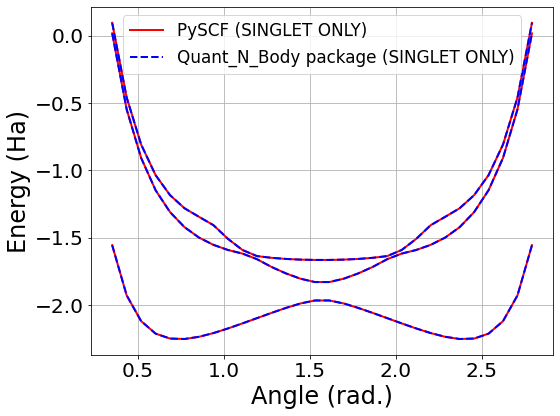

In [16]:
import matplotlib.pyplot as plt

plt.rc('font',  family='serif')
plt.rc('font',  serif='Times New Roman')
plt.rc('font',  size='14') 
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large') 
plt.rc('lines', linewidth='2') 

# Plotting the resulting energies
fig, ( ax1 ) = plt.subplots( nrows=1, ncols=1, figsize=(8, 6)  ) 
for i in range(3):
    if i ==0:
        ax1.plot( list_theta, Energies_FCI[:,i], color='red' , label='PySCF (SINGLET ONLY)' ) 
    else:
        ax1.plot( list_theta, Energies_FCI[:,i], color='red'   ) 
for i in range(3):
    if i ==0: 
        ax1.plot( list_theta, Energies_FCI_me[:,i], color='blue', ls='--' , label='Quant_N_Body package (SINGLET ONLY)'    )  
    else:
        ax1.plot( list_theta, Energies_FCI_me[:,i], color='blue', ls='--'   ) 
 
ax1.grid()

ax1.set_ylabel('Energy (Ha)', size=24)
ax1.set_xlabel('Angle (rad.)', size=24)
ax1.legend(fontsize='large', ncol=1)

plt.tight_layout()

plt.savefig('PES_H4_ring.pdf')
  
plt.show()
 
 

## Let's understand what is hidden under the carpet

We need first to create a list of state that will define the occupancies of the electrons in the spin-orbitals of the system.

### Size of the many-body Fockspace
First the size of the many-body Hilbert space follows the binomial term 
$$\binom{2N_{MO}}{N_{elec}}$$

In [17]:
N_MO = N_elec = 2
dim_H = math.comb(2 * N_MO, N_elec)

print('Dimension of the basis :', dim_H, 'states')

Dimension of the basis : 6 states


### Building the list of many-body states (with label $\kappa$)

In [18]:
list_fockstates = []
kappa = 0
print('kappa   fockstate')

for combination in combinations(range(2 * N_MO), N_elec): #<== Native python combinatorial calculation !!
    
    fockstate = [0 for i in range(2 * N_MO)]
    
    for index in list(combination):
        fockstate[ index ] += 1
        
    list_fockstates += [ fockstate ]  
    
    print(kappa,'     ', fockstate)
    kappa += 1
     

kappa   fockstate
0       [1, 1, 0, 0]
1       [1, 0, 1, 0]
2       [1, 0, 0, 1]
3       [0, 1, 1, 0]
4       [0, 1, 0, 1]
5       [0, 0, 1, 1]


### Function to encode the effects of a creation/annihilation operation

The idea here is to create a method that can formally reproduce the effect of the operators $a^\dagger/a$ over a given many-body state.

$$
a_{SO}^{\dagger }|\cdots ,n_{SO-1},n_{SO},n_{SO+1},\cdots \rangle 
=
\color{red}{
(-1)^{\textstyle\sum_{SO' <SO } n_{SO' }}}
\sqrt {1-n_{SO}} \quad  \color{blue}{|\cdots ,n_{SO-1 },n_{SO }+1,n_{SO+1 },\cdots \rangle}
$$

This method should then return two things: 
- $\color{red}{\text{a phase factor}}$
- $\color{blue}{\text{a new many-body state}}$

Here is below such a function

In [19]:
def new_state_after_SQ_fermi_op( type_of_op, index_mode, ref_fockstate  ):
     
    new_fockstate = ref_fockstate.copy()
    coeff_phase = 1
    
    if ( type_of_op == 'a' and ref_fockstate[index_mode] == 1 ):  
        
        new_fockstate[ index_mode ] += -1
        
        if ( index_mode > 0 ): 
            
            coeff_phase = (-1.) ** np.sum( ref_fockstate[0:index_mode] ) 
            
    elif ( type_of_op == 'a^' and ref_fockstate[index_mode] == 0): 
        new_fockstate[ index_mode ] += 1
        if ( index_mode > 0 ):
            coeff_phase = (-1.) ** np.sum( ref_fockstate[0:index_mode] )  
    else:
        print(' ERROR !! Not a state !!! ')
        new_fockstate, coeff_phase = 0, 0
        
    return new_fockstate, coeff_phase


### Little illustration with the initial state $| 1100\rangle$. 

We first check the effect of $ a^\dagger_{1,\uparrow} | 1100\rangle$.

Here, note that the spin-orbital label is translated $(1,\uparrow) \longrightarrow 2*index_{MO} = 2$

In [20]:
TEST_WFT = [ 1, 1, 0, 0 ]

new_fockstate, coeff_phase =  new_state_after_SQ_fermi_op ( type_of_op    ='a^',
                                                            index_mode    = 2,
                                                            ref_fockstate = TEST_WFT)
print( 'Initial state   ', TEST_WFT)
print( 'Final state   ', coeff_phase, ' x ', new_fockstate)

Initial state    [1, 1, 0, 0]
Final state    1.0  x  [1, 1, 1, 0]


### Building the operators $a^\dagger_{p,\sigma} a_{q,\sigma}$

As stated earlier, the key elements to build all important matrices (Hamiltonian, RDMs ...) are the $a^\dagger_{p,\sigma} a_{q,\sigma}$ operators. We need here to encode the matrix representation of these operators in the many-body basis such that

$$ a^\dagger_{p,\sigma} a_{q,\sigma} = \sum_{\kappa, \kappa' 
 =1}^{\dim_H}  \langle \kappa' | a^\dagger_{p,\sigma} a_{q,\sigma} | \kappa  \rangle  \; | \kappa'    \rangle\langle \kappa |  $$

To do so, we have to check how each operator act on an initial state to obtain a mapping in the many-body basis. In other words, we have to do as follows : 

$$ a^\dagger_{p,\sigma} a_{q,\sigma} |\kappa \rangle = |\kappa' \rangle $$

and check what is the final state $| \kappa' \rangle$

**How to do that ?**

- Go through the list of many-body states $|\kappa \rangle$
- For each $|\kappa \rangle$, compute the action of $ a_{q,\sigma}$ and then $a^\dagger_{p,\sigma}$ which returns two phases $p1$ and $p2$ and a final state $|\kappa ' \rangle$ 

- Find in the original list of many-body state which index $\kappa'$ refers to the final state $|\kappa ' \rangle$ 

- Write the matrix element  $\langle\kappa' |a^\dagger_{p,\sigma} a_{q,\sigma} |\kappa \rangle = p1 \times p2$

And that's it !

In [21]:
a_dagger_a = np.zeros((2*N_MO, 2*N_MO), dtype=object)
for p in range(2*N_MO):
    for q in range(2*N_MO): 
        a_dagger_a[p,q] = scipy.sparse.lil_matrix(( dim_H, dim_H ))

for kappa in range(dim_H):  
    
    ref_state = list_fockstates[ kappa ]
    
    for q in range(2*N_MO):
        if ( ref_state[q] == 0 ): continue
        state_one, p1 = new_state_after_SQ_fermi_op('a', q,  ref_state)  
        
        for p in range(2*N_MO):  
            if ( state_one[p] == 1 ): continue
            state_two, p2 = new_state_after_SQ_fermi_op('a^', p,  state_one)  
            
            kappa_ = list_fockstates.index( state_two ) # <=== Find the element kappa' in the list of MBstates
            
            a_dagger_a[p,q][kappa_,kappa] = p1 * p2

### Building the hamiltonian
In a more general basis, which is not necessarily composed of local orbitals, the same hamiltonian reads

$$   
\hat{H} =\sum_{\langle p,q \rangle}^{N_{MO}} -h_{pq} \sum_{\sigma=\uparrow,\downarrow} (\hat{a}^\dagger_{p,\sigma}\hat{a}_{q,\sigma}+\hat{a}^\dagger_{q,\sigma}\hat{a}_{p,\sigma}) + \sum_i^{N_{MO}} U_{p,q,r,s} \hat{a}^\dagger_{p,\uparrow}\hat{a}_{q,\uparrow} \hat{a}^\dagger_{r,\downarrow}\hat{a}_{s,\downarrow} 
 $$

In [22]:
# Building the N-electron Fermi-Hubbard matrix hamiltonian (Sparse)
H_Fermi_Hubbard = scipy.sparse.csr_matrix((dim_H, dim_H)) 
for p in range(N_MO):  
    for q in range(N_MO): 
        
        H_Fermi_Hubbard += ( a_dagger_a[2*p,2*q] + a_dagger_a[2*p+1,2*q+1] ) *  h_[p,q]  
        
        for r in range(N_MO): 
            for s in range(N_MO):  
                
                H_Fermi_Hubbard +=  a_dagger_a[2*p,2*q] @ a_dagger_a[2*r+1,2*s+1]  *  U_[p,q,r,s]

eig_energies, eig_vectors =  scipy.linalg.eigh(H_Fermi_Hubbard.A) 

In [23]:
print( H_Fermi_Hubbard )

  (0, 0)	-1.0
  (0, 2)	-1.0
  (0, 3)	1.0
  (1, 1)	-3.0
  (2, 0)	-1.0
  (2, 2)	-3.0
  (2, 5)	-1.0
  (3, 0)	1.0
  (3, 3)	-3.0
  (3, 5)	1.0
  (4, 4)	-3.0
  (5, 2)	-1.0
  (5, 3)	1.0
  (5, 5)	-2.0


In [24]:
print( H_Fermi_Hubbard.A )

[[-1.  0. -1.  1.  0.  0.]
 [ 0. -3.  0.  0.  0.  0.]
 [-1.  0. -3.  0.  0. -1.]
 [ 1.  0.  0. -3.  0.  1.]
 [ 0.  0.  0.  0. -3.  0.]
 [ 0.  0. -1.  1.  0. -2.]]


### Let us build the RDMs (spin-free 1RDM and on-site 2-RDM)

In [25]:
WFT = eig_vectors[:,0]

one_rdm = np.zeros(( N_MO, N_MO ))
for p in range(N_MO):
    for q in range(N_MO):  
        E_pq = a_dagger_a[ 2*p, 2*q ] + a_dagger_a[ 2*p+1, 2*q+1 ]
        one_rdm[p,q] = WFT.T @ E_pq @ WFT 
        
two_RDM_FH = np.zeros(( N_MO, N_MO, N_MO, N_MO ))
for p in range(N_MO):  
    for q in range(N_MO):   
        for r in range(N_MO): 
            for s in range(N_MO):  
                two_RDM_FH[p,q,r,s] += (
                    WFT.T @ a_dagger_a[2*p,2*q] @ a_dagger_a[2*r+1,2*s+1]  @ WFT )
 

Let's compute the associated energy

$$ E_0 = \sum_{pq} h_{pq} \text{1-RDM}_{pq} + \sum_{pqrs} U_{pqrs} \text{2-RDM}^{FH}_{pqrs}$$

with 
$$  \text{1-RDM}_{pq} = \langle \Psi_0| \sum_\sigma    a^\dagger_{p,\sigma}a^\dagger_{q,\sigma} | \Psi_0 \rangle $$

and 

$$ \text{2-RDM}_{pqrs}^{FH} = \langle \Psi_0| \hat{a}^\dagger_{p,\uparrow}\hat{a}_{q,\uparrow} \hat{a}^\dagger_{r,\downarrow}\hat{a}_{s,\downarrow} | \Psi_0 \rangle $$

In [26]:
E_0 = np.einsum('pq,pq', h_, one_rdm) +   np.einsum('pqrs,pqrs', U_ , two_RDM_FH)

print( 'Energy with Diag. : ', eig_energies[0] )
print( 'Energy with RDMs  : ', E_0 )

Energy with Diag. :  -4.414213562373092
Energy with RDMs  :  -4.414213562373095


## Conclusion : a few lines and we have a Hamiltonian

In [27]:
# Setup for the simulation ========
N_MO   = N_elec = 2 
dim_H = math.comb( 2*N_MO, N_elec ) # Dimension of the many-body space

t_  = np.zeros((N_MO,N_MO))
U_  = np.zeros((N_MO,N_MO,N_MO,N_MO))
Mu_ = np.zeros((N_MO,N_MO)) 
for i in range(N_MO): 
    U_[i,i,i,i]  =  1 * (1+i)   # Local coulombic repulsion 
    Mu_[i,i]     = -1 * (1+i)   # Local chemical potential
    
    for j in range(i+1,N_MO): 
        t_[i,j] = t_[j,i] = - 1  # hopping

h_ = t_  + np.diag( np.diag(Mu_) ) # Global one-body matrix = hoppings + chemical potentials

mol = qnb.Hamiltonian(N_MO, N_elec)
mol.build_operator_a_dagger_a()
mol.build_hamiltonian_fermi_hubbard(h_, U_)

# or alternatively

nbody_basis = qnb.tools.build_nbody_basis(N_MO, N_elec)                       # <=== FCT IN THE PACKAGE
a_dagger_a  = qnb.tools.build_operator_a_dagger_a(nbody_basis)                # <=== FCT IN THE PACKAGE
H           = qnb.tools.build_hamiltonian_fermi_hubbard(h_, U_,  nbody_basis, a_dagger_a) # <=== FCT IN THE PACKAGE

# ( ... )


	 ====  The matrix form of a^a is built  ====
